In [1]:
import keras
import tensorflow as tf
import os
import numpy as np
import time
import pprint
import matplotlib.pyplot as plt

In [2]:
!pip install gymnasium
!pip install -q git+https://github.com/eleurent/highway-env
!pip install -q git+https://github.com/DLR-RM/stable-baselines3

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import gymnasium as gym
import highway_env
from matplotlib import pyplot as plt
%matplotlib inline
from stable_baselines3 import DQN, PPO

from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import Figure, Image

In [4]:
# Visualization utils
%load_ext tensorboard
import sys
from tqdm.notebook import trange
!pip install tensorboardx gym pyvirtualdisplay
!apt-get install -y xvfb ffmpeg
!git clone https://github.com/Farama-Foundation/HighwayEnv.git 2> /dev/null
sys.path.insert(0, '/content/HighwayEnv/scripts')
#from utils import record_videos, show_videos

'apt-get' is not recognized as an internal or external command,
operable program or batch file.
The system cannot find the path specified.


### __Configuration of the Roundabout Environment__
###### Separated it out to change reward function for speed, lane keeping, and collision prevention

In [5]:
env_config= {
            "observation": {
                "type": "Kinematics",
                "absolute": True,
                "features_range": {
                    "x": [-100, 100],
                    "y": [-100, 100],
                    "vx": [-15, 15],
                    "vy": [-15, 15],
                },
            },
            "action": {"type": "DiscreteMetaAction", "target_speeds": [0, 8, 16]},
            "incoming_vehicle_destination": None,
            "collision_reward": -0.2,
            "high_speed_reward": 0.8,
            "right_lane_reward": 0.1,
            "lane_change_reward": -0.1,
            "screen_width": 600,
            "screen_height": 600,
            "centering_position": [0.5, 0.6],
            "duration": 11,
            "normalize_reward": True,
        }

In [6]:
def env_create(seed=42):
    env = gym.make("roundabout-v0", config=env_config, render_mode='rgb_array')
    # pprint.pprint(env.unwrapped.config)
    env.reset(seed=seed)
    return env

env = env_create()
pprint.pprint(env.unwrapped.config) # Print all the env parameters

{'action': {'target_speeds': [0, 8, 16], 'type': 'DiscreteMetaAction'},
 'centering_position': [0.5, 0.6],
 'collision_reward': -0.2,
 'duration': 11,
 'high_speed_reward': 0.8,
 'incoming_vehicle_destination': None,
 'lane_change_reward': -0.1,
 'manual_control': False,
 'normalize_reward': True,
 'observation': {'absolute': True,
                 'features_range': {'vx': [-15, 15],
                                    'vy': [-15, 15],
                                    'x': [-100, 100],
                                    'y': [-100, 100]},
                 'type': 'Kinematics'},
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'right_lane_reward': 0.1,
 'scaling': 5.5,
 'screen_height': 600,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 15}


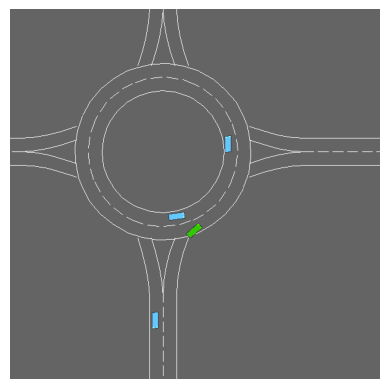

In [7]:
for _ in range(3):
    action = env.unwrapped.action_type.actions_indexes["IDLE"]
    obs, reward, done, truncated, info = env.step(action)
    env.render()

plt.imshow(env.render()) # draw the current scenario
plt.axis('off')
plt.show()

Key aspects of ``ep_len_mean`` and ``ep_rew_mean`` can be seen on tensorboard. But, to also notice loss, we need a separate callback

In [8]:
# Custom callback to log loss
class LossCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(LossCallback, self).__init__(verbose)
        self.losses = []

    def _on_step(self):
        # Log loss after each update
        if "train/loss" in self.logger.name_to_value:
            loss = self.logger.name_to_value["train/loss"]
            self.losses.append(loss)
        return True

loss_callback = LossCallback()

In [9]:
#%tensorboard --logdir "highway_ppo"

In [10]:
model = PPO('MlpPolicy', env,
                policy_kwargs=dict(net_arch=[256, 256]),
                learning_rate=25e-5,
                n_steps=2048,
                n_epochs=10,
                batch_size=64,
                gamma=0.9,
                gae_lambda=0.9,
                clip_range=0.2,
                ent_coef=0.01,
                vf_coef=0.5,
                max_grad_norm=0.5,
                verbose=1,
                tensorboard_log='highway_ppo/')

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [11]:
start = time.perf_counter()
model.learn(total_timesteps=20000, callback=loss_callback)
end = time.perf_counter()

s2mps = lambda s: f"{s // 60:.0f} min {s % 60:.2f} s"
print(f"Time to run: {s2mps(end - start)}")

Logging to highway_ppo/PPO_1


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.82     |
|    ep_rew_mean     | 4.64     |
| time/              |          |
|    fps             | 17       |
|    iterations      | 1        |
|    time_elapsed    | 120      |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.02        |
|    ep_rew_mean          | 5.8         |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 2           |
|    time_elapsed         | 241         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.032837614 |
|    clip_fraction        | 0.344       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.58       |
|    explained_variance   | -0.0522     |
|    learning_rate        | 0.

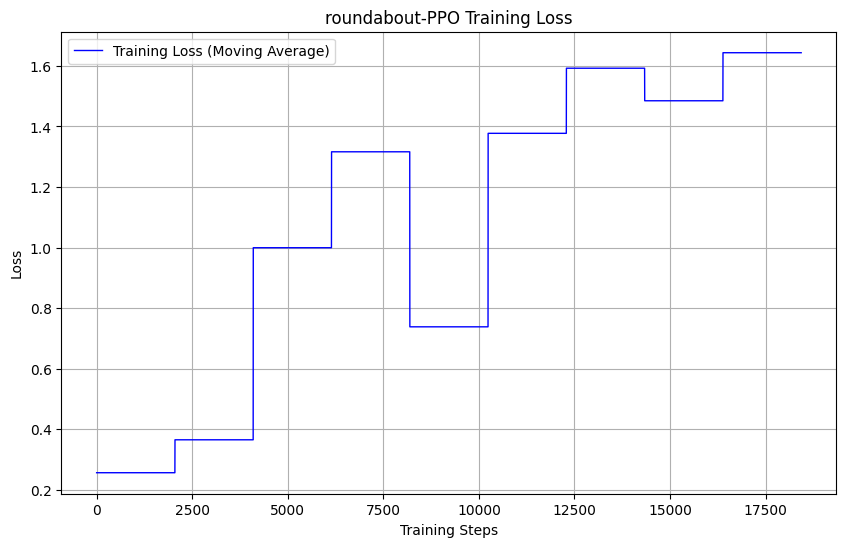

In [12]:
# Plotting the moving average of loss
plt.figure(figsize=(10, 6))
plt.plot(loss_callback.losses, label='Training Loss (Moving Average)', color='blue', linewidth=1)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('roundabout-PPO Training Loss')
plt.legend()
plt.grid()
plt.show()

In [13]:
n_tests = 25
total_failtime = []
total_distance = []
total_reward = []
simulation_frequency = 15

for ix in range(n_tests):
    timetofail = 0
    distance = 0
    sumreward = 0
    done = truncated = False

    obs, info = env.reset()
    # Run the episode until termination (either done or truncated)
    while not (done or truncated):

        # Use the trained model to predict the next action deterministically and executing the action in env
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)

        timetofail += 1
        sumreward += reward
        distance += info['speed'] / simulation_frequency

    # Append the results of this episode to the respective lists
    total_failtime.append(timetofail)
    total_distance.append(distance)
    total_reward.append(sumreward)

# Calculate and print the average results across all test episodes
print(f'Avg time to fail [s] = {np.sum(total_failtime) / n_tests / simulation_frequency:.2f}')
print(f'Avg distance traveled [m]= {np.sum(total_distance) / n_tests:.2f}')
print(f'Avg reward = {np.sum(total_reward) / n_tests:.2f}')

Avg time to fail [s] = 0.37
Avg distance traveled [m]= 5.62
Avg reward = 5.48


__Reward Function:__

We do not need to experiment with reward function for collision, high_speed, etc. as we collected appropriate values for them in DQN experiment.

We will experiment with ``PPO`` parameters, and as loss appear to not decrease smoothly, we will start with ``gae_lambda``
```
model = PPO("MlpPolicy", env,
             policy_kwargs=dict(net_arch=[256, 256]),
             learning_rate=5e-4,
             n_steps=2048,
             batch_size=32,
             n_epochs=10,
             gamma=0.95,
             gae_lambda=0.98,
             clip_range=0.2,
             ent_coef=0.01,
             verbose=1,
             tensorboard_log='highway_ppo/')
```

| Ex. No. |learning_rate |n_steps |gae_lambda|clip_range | ent_coef |Avg Time |Avg Distance | Avg Reward|
|----|----|----|----|---|---|---|---|---|
|1| 5e-4 | 2048 | 0.98 | 0.2|0.01|0.73|2.58|8.93|
|2|5e-4|2048|0.95|0.2|0.01|0.73|0.47|8.54|
|3|5e-4|2048|0.90|0.2|0.01|0.73|2.25|8.93|
|4|__25e-5__ | __2048__ | __0.98__|__0.2__| __0.01__|**0.73**|__3.49__|__9.21__|
|5|3e-4 | 2048 | 0.98|0.2| 0.01|0.73|2.00|8.84|
|6|25e-5 | 1024 | 0.98|0.2| 0.01|0.73|0.11|8.43|
|7|25e-5 | 2048 | 0.98|0.1| 0.01|0.73|3.05|9.12|
|8|25e-5 | 2048 | 0.98|0.2| 0.001|0.73|1.84|8.84|



           

I was not recording video, therefore kept trying. However, __ego vehicle remain stagnant for the first few seconds to avoid collision__

Therefore, __changed__ ``reward function`` in a way __ego vehicle start movement as soon as episode starts__ Our chosen values are:
```
"collision_reward": -0.2,
"high_speed_reward": 0.8,
"right_lane_reward": 0.1,
"lane_change_reward": -0.1,
```



| Ex. No. |learning_rate |n_steps |Discount | gae_lambda|clip_range | ent_coef |Avg Time |Avg Distance | Avg Reward| REMARK |
|----|------|------|-----|------|-----|------|------|------|------|---------------------------------|
| 1 | 25e-5 | 2048 | 0.9 | 0.95 | 0.2 | 0.001| 0.58 | 7.87 | 7.44 | Rear-collided at Roundabout Exit|
| 2 | 25e-5 | 2048 | 0.9 | 0.95 | 0.2 | 0.01 | 0.52 | 8.04 | 7.68 |__Cleared RoundAbout__ Loss Monotonic Increase|
| 3 | 25e-5 | 2048 | 0.9 | 0.95 | 0.1 | 0.01 | 0.59 | 7.54 | 7.49 | Rear-collided at Roundabout Exit|
| 4 | 25e-5 | 2048 | 0.9 | 0.9  | 0.2 | 0.01 | 0.45 | 6.82 | 6.42 |__Cleared RoundAbout__|

In [15]:
# if True:
#     env = env_create()
#     env = record_videos(env)

#     # Loop through a specified number of test episodes to evaluate the model
#     for episode in trange(2, desc='Test episodes'):
#         (obs, info), done = env.reset(), False
#         while not done:
#             # Use the trained model to predict the next action deterministically
#             action, _ = model.predict(obs, deterministic=True)

#             # Take the predicted action in the environment and observe the results
#             obs, reward, done, truncated, info = env.step(int(action))

#     env.close()
#     show_videos()